In [1]:
from train import *
from model import *
from helpers import *
from include import *

import os
import plac
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from IPython.display import clear_output

import numpy as np
from PIL import Image

import torch
from torch import nn, Tensor
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.datasets as dset


GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


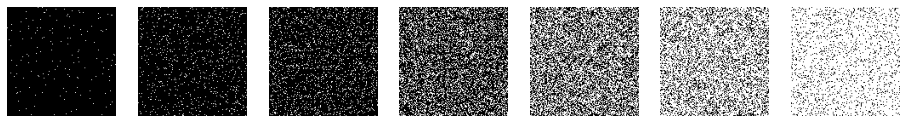

In [9]:
num_of_low_shots = 10
num_of_val = 24
image_size = 128

# given mask
img_mask_pil = Image.open('./mask.png')
mask_np = pil_to_np(img_mask_pil)
mask_var = np_to_var(mask_np).type(dtype) # float within 0~1

# random masks
ratios = np.array([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9])
masks = torch.zeros(len(ratios), 3, image_size, image_size).type(dtype)

plt.figure(figsize=(16, 8))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    tmp = torch.cuda.FloatTensor(1, 1, image_size, image_size).uniform_() < ratios[i]
    tmp = tmp.view(-1, 1, 128, 128)
    
    mask_np = var_to_np(tmp)
    mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * 3)
    masks[i] = np_to_var(mask_np).type(dtype)

    plt.imshow(mask_np.transpose(1, 2, 0))
    plt.axis('off');

In [10]:
# low shots
# Root directory for dataset
data_root = "./CelebA_data/celeba"

batch_size = 2
data_set = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor() ]))

random.seed(5)
img_lib = np.arange(45, len(data_set), 1)
random.shuffle(img_lib)
print(img_lib)

[158437 136381 157264 ... 194500  67008 163334]


In [11]:
train_set = IndexedDataset(torch.utils.data.Subset(data_set, img_lib[:num_of_low_shots]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# validate specific images
val_set = IndexedDataset(torch.utils.data.Subset(data_set, range(24, 44, 1)))
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=1)

In [5]:
code_dim = 128
k = 128
num_channels = [k]*3
Z = np.random.normal(size=(num_of_low_shots, code_dim)).astype(np.float32)
Z = torch.tensor(Z, requires_grad=True).type(dtype)

LV = latent_var(Z).type(dtype)
# deep_decoder = fixed_decodernw(num_channels_up=num_channels, upsample_mode='bilinear').type(dtype)
dcgan_decoder0 = dcgan(code_dim).type(dtype)

In [6]:
g = CombinedNets(LV, dcgan_decoder0).type(dtype)
g.apply(weight_init)
print(get_n_params(g))
print(g)

13246592
CombinedNets(
  (Z): latent_var()
  (Decoder): dcgan(
    (dcnn): Sequential(
      (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(128, 64,

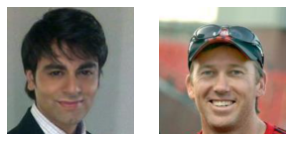

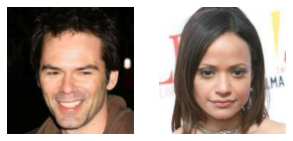

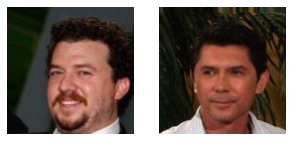

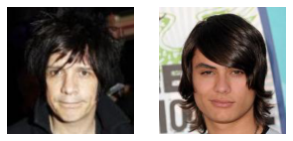

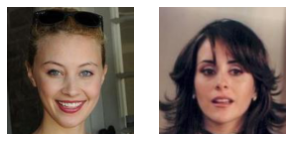

In [7]:
# prepare for pre-train
loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(g.parameters(), lr=learning_rate)

for i, (train_image, _, _) in enumerate(train_loader):
    plt.figure(figsize=(5, 5))
    for i in range(len(train_image)):
        plt.subplot(1, len(train_image), i + 1)
        imgshow(train_image[i])
        plt.axis('off');

In [8]:
# pre-train
n_epochs = 5000
save_root = "./low_shots_celeb/checkpoint/"

g, Z = pre_train(n_epochs, 
                 train_loader, 
                 g, 
                 Z,
                 optimizer, 
                 dcgan_decoder0,
                 save_root,
                 dtype)

pre-train epoch: 200 	 average loss: 0.001430
pre-train epoch: 400 	 average loss: 0.000669
pre-train epoch: 600 	 average loss: 0.000257
pre-train epoch: 800 	 average loss: 0.000202
pre-train epoch: 1000 	 average loss: 0.000281
pre-train epoch: 1200 	 average loss: 0.000235
pre-train epoch: 1400 	 average loss: 0.000156
pre-train epoch: 1600 	 average loss: 0.000094
pre-train epoch: 1800 	 average loss: 0.000120
pre-train epoch: 2000 	 average loss: 0.000085
pre-train epoch: 2200 	 average loss: 0.000093
pre-train epoch: 2400 	 average loss: 0.000085
pre-train epoch: 2600 	 average loss: 0.000048
pre-train epoch: 2800 	 average loss: 0.000068
pre-train epoch: 3000 	 average loss: 0.000045
pre-train epoch: 3200 	 average loss: 0.000056
pre-train epoch: 3400 	 average loss: 0.000054
pre-train epoch: 3600 	 average loss: 0.000091
pre-train epoch: 3800 	 average loss: 0.000105
pre-train epoch: 4000 	 average loss: 0.000035
pre-train epoch: 4200 	 average loss: 0.000039
pre-train epoch: 

In [13]:
# prepare for training
loss_fn = nn.MSELoss()
code_dim = 128
epoch_for_train_z = 1250
epoch_for_joint_train = 350

# final_output = torch.zeros((num_of_val, 3, image_size, image_size)).type(dtype)
# final_z_dict = torch.zeros((num_of_val, 1, code_dim)).type(dtype)
psnr_list = np.zeros(num_of_val)

def train_all_val(mask):
    mask = mask.type(dtype)
    for i_batch, (img_clean_var, _, _) in enumerate(val_loader):
        progress = tqdm(total=1, desc='loop % 3d' % i_batch)
        # for image i
        img_clean_var = Variable(img_clean_var).type(dtype)
        img_noisy_var = (img_clean_var * mask).type(dtype)

        # load pre-trained decoder
        dcgan_decoder = dcgan(code_dim).type(dtype)
        if os.path.isfile(save_root + ('dcgan_pre_%d_shots.pt' % num_of_low_shots)):
            dcgan_decoder.load_state_dict(torch.load(save_root + ('dcgan_pre_%d_shots.pt' % num_of_low_shots)))
            Z = torch.load(save_root + "Z.pt")
        else:
            dcgan_decoder.apply(weight_init)

        # initial z
        target_z = sample_multivar_normal(Z, code_dim).type(dtype)

        # combined model train_g
        LV_target_z = latent_var(target_z).type(dtype)
        train_g = CombinedNets(LV_target_z, dcgan_decoder).type(dtype)

        # train phase: train z to find z_hat
        target_z_hat, _ = train(epoch_for_train_z, 
                                img_noisy_var, 
                                train_g, 
                                dcgan_decoder, 
                                target_z, 
                                joint_train=False,
                                learning_rate=5 * 1e-4,
                                dtype=dtype,
                                mask=mask,
                                measure=None)

        # train phase: joint train
        warm_start_z = latent_var(target_z_hat).type(dtype)
        joint_train_g = CombinedNets(warm_start_z, dcgan_decoder).type(dtype)

        final_z, final_G = train(epoch_for_joint_train, 
                                 img_noisy_var, 
                                 joint_train_g,
                                 dcgan_decoder, 
                                 target_z_hat, 
                                 joint_train=True,
                                 learning_rate=1e-4,
                                 dtype=dtype,
                                 mask=mask,
                                 measure=None)

#         final_output[i_batch] = final_G
#         final_z_dict[i_batch] = final_z
        psnr_list[i_batch] = psnr(img_clean_var.cpu().numpy(), final_G.detach().cpu().numpy())

        progress.set_postfix({'loss': loss_fn(final_G * mask, img_clean_var * mask).item()})
        progress.update()
        
    return np.mean(psnr_list)

In [ ]:
# pretraining on 24 shots
average_pnsr_list_24_shots = []
for ratio, mask in zip(ratios, masks):
    print("for ratio:", ratio)
    snr = train_all_val(mask)
    average_pnsr_list_24_shots.append(snr)
    print("psnr = ", snr)
    clear_output(wait=True)

for ratio: 0.05


In [ ]:
print(average_pnsr_list_24_shots)
plt.plot(ratios, average_pnsr_list_24_shots)
plt.title('24 shots')

In [10]:
# visual exam
final_output = torch.zeros((num_of_val, 3, image_size, image_size)).type(dtype)
final_z_dict = torch.zeros((num_of_val, 1, code_dim)).type(dtype)
psnr_list = np.zeros(num_of_val)

code_dim = 128
epoch_for_train_z = 1250
epoch_for_joint_train = 350

mask = masks[5].type(dtype)
for i_batch, (img_clean_var, _, _) in enumerate(val_loader):
    progress = tqdm(total=1, desc='loop % 3d' % i_batch)
    # for image i
    img_clean_var = Variable(img_clean_var).type(dtype)
    img_noisy_var = (img_clean_var * mask).type(dtype)

    # load pre-trained decoder
    dcgan_decoder = dcgan(code_dim).type(dtype)
    if os.path.isfile(save_root + ('dcgan_pre_%d_shots.pt' % num_of_low_shots)):
        dcgan_decoder.load_state_dict(torch.load(save_root + ('dcgan_pre_%d_shots.pt' % num_of_low_shots)))
        Z = torch.load(save_root + "Z.pt")
    else:
        dcgan_decoder.apply(weight_init)

    # initial z
    target_z = sample_multivar_normal(Z, code_dim).type(dtype)

    # combined model train_g
    LV_target_z = latent_var(target_z).type(dtype)
    train_g = CombinedNets(LV_target_z, dcgan_decoder).type(dtype)

    # train phase: train z to find z_hat
    target_z_hat, _ = train(epoch_for_train_z, 
                            img_noisy_var, 
                            train_g, 
                            dcgan_decoder, 
                            target_z, 
                            joint_train=False,
                            learning_rate=5 * 1e-4,
                            dtype=dtype,
                            mask=mask,
                            measure=None)

    # train phase: joint train
    warm_start_z = latent_var(target_z_hat).type(dtype)
    joint_train_g = CombinedNets(warm_start_z, dcgan_decoder).type(dtype)

    final_z, final_G = train(epoch_for_joint_train, 
                         img_noisy_var, 
                         joint_train_g,
                         dcgan_decoder, 
                         target_z_hat, 
                         joint_train=True,
                         learning_rate=1e-4,
                         dtype=dtype,
                         mask=mask,
                         measure=None)

    final_output[i_batch] = final_G
    final_z_dict[i_batch] = final_z
    psnr_list[i_batch] = psnr(img_clean_var.cpu().numpy(), final_G.detach().cpu().numpy())

    progress.set_postfix({'loss': loss_fn(final_G * mask, img_clean_var * mask).item()})
    progress.update()
    
    if i_batch == 9:
        break

In [13]:
# visual results for inpainting task
def myimgshow(plt, img):
    plt.imshow(np.clip(img.data.cpu().numpy().squeeze().transpose(1, 2, 0), 0, 1))

def plot_all(plt, i):
    img_val, _, _ = val_set[i]
    img_val = img_val.type(dtype)
    
    fig = plt.figure(figsize = (15,15)) 
    
    ax1 = fig.add_subplot(131)
    myimgshow(ax1, img_val)
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(132)
    myimgshow(ax2, img_val * mask)
    ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_val.cpu().numpy(), (img_val.cpu().numpy() * mask.cpu().numpy())))
    ax2.axis('off')

    ax3 = fig.add_subplot(133)
    myimgshow(ax3, final_output[i])
    ax3.set_title( "Recovered image, PSNR: %.2f" % psnr(img_val.cpu().numpy(), final_output[i].detach().cpu().numpy()) ) 
    ax3.axis('off')

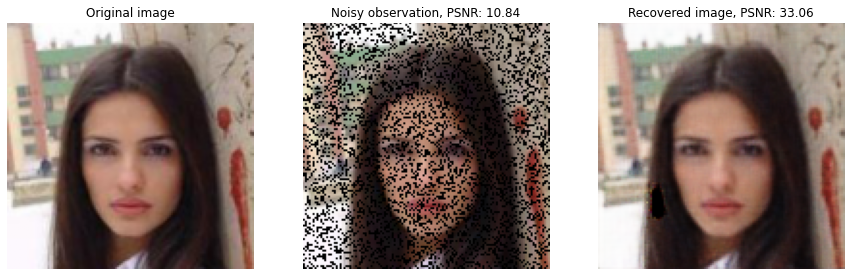

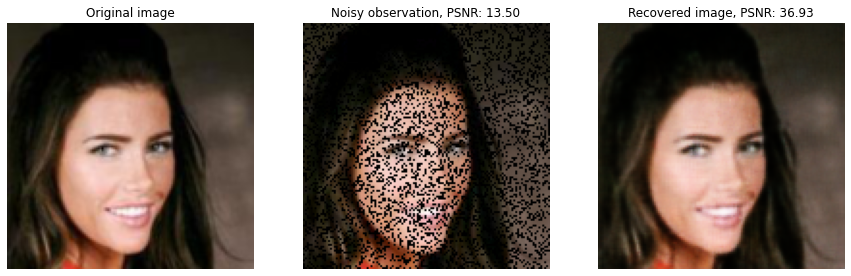

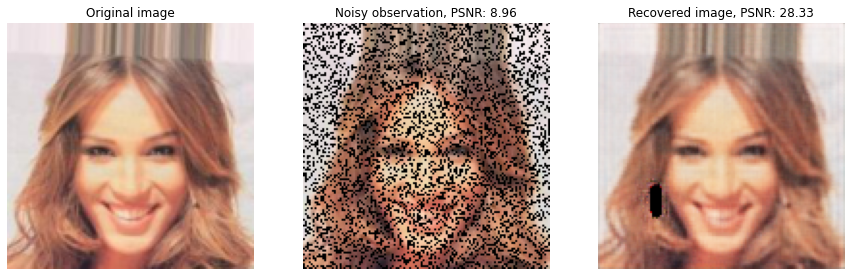

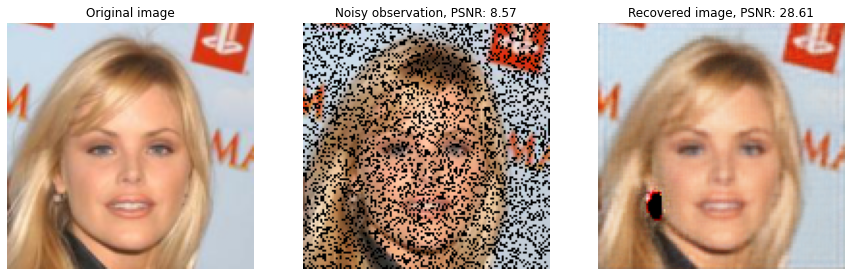

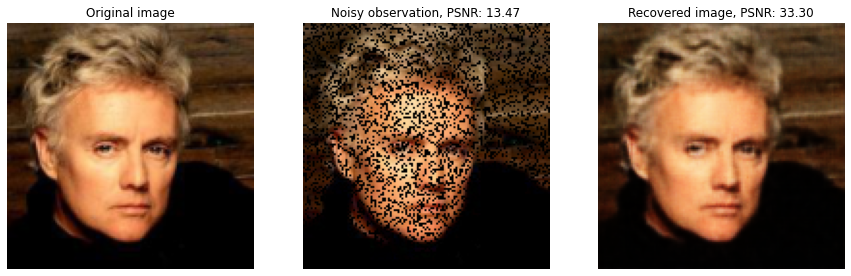

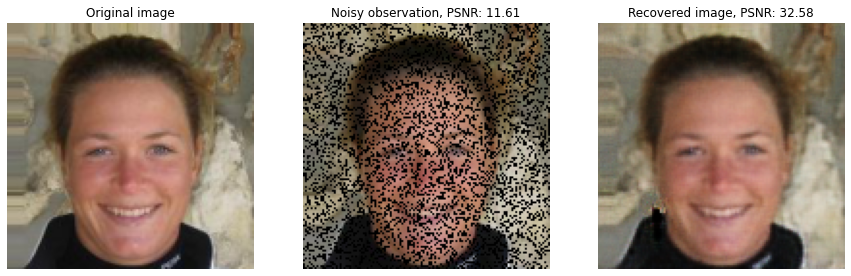

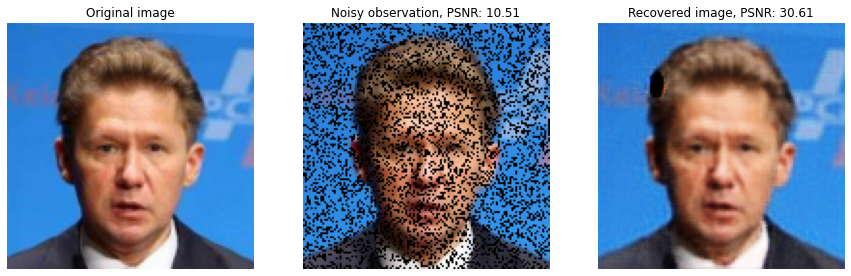

In [14]:
for i in range(1, 8):
    plot_all(plt, i)